# Short term trading strategies that work

In this notebook, strategies mentioned in the book 'Short term trading strategies that work' from Larry Connors are investigated. This book mainly focuses on short-term mean-reversion strategies in the US equity market.

In [1]:
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import pytz
import matplotlib.pyplot as plt
plt.style.use('bmh')

from vivace.backtest import (BacktestEngine, InstrumentDef,
                             Performance, signal, processing, rebase)
from vivace.backtest.engine import long_only_returns
from vivace.enums import Strategy, Weighting, PnLType

# Strategy 1
If the following conditions are met, go long the equity market for 5 days.
- It went down 3 days in a row
- Price is above 200 day MA. Rationale is to go long when long-term trend is up and capture temporal pullback.

In [2]:
instruments = ['SPY', 'QQQ', '^GDAXI', '^N225']

In [3]:
def run_strat_1(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.ConsecutiveSign(n_consecutive=3, lookback_direction=-1, position=1)
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine


def run_backtests(backtest_func, instruments):
    result = []

    for name in instruments:
        instrument = InstrumentDef(name, pnl_type=PnLType.ADJCLOSE_TO_ADJCLOSE.value)
        strat_engine = backtest_func(instrument)
        strat_equity_curve = strat_engine.calculate_equity_curve(calculate_net=False).rename(f'Strategy ({name})')
        long_only = long_only_returns(instrument, strat_equity_curve.index[0], strat_equity_curve.index[-1])
        long_only_equity_curve = long_only.add(1).cumprod().rename(f'Long-only ({name})')

        result.append(
            pd.concat((long_only_equity_curve, strat_equity_curve), axis=1).pipe(rebase)
        )
    return result

In [4]:
strategy_1_result = run_backtests(run_strat_1, instruments)

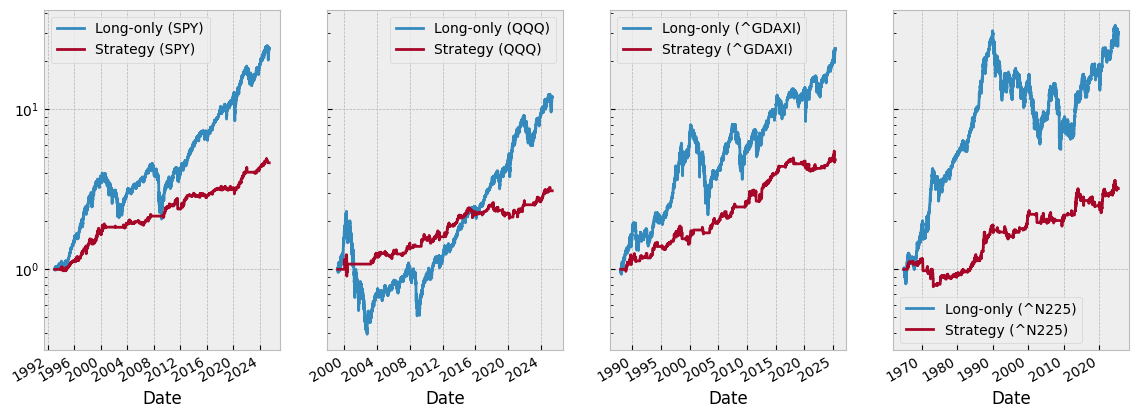

In [5]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_1_result):
    result.plot(ax=ax, logy=True)

In [6]:
pd.concat([i.pipe(Performance).summary() for i in strategy_1_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.098551,0.047472,0.094918,0.043171,0.084541,0.041987,0.057829,0.019730
Annualised vol,0.187460,0.071724,0.272596,0.098519,0.218252,0.082238,0.202727,0.075845
Sharpe ratio,0.525719,0.661872,0.348202,0.438202,0.387356,0.510556,0.285253,0.260141
Max drawdown,0.551895,0.140755,0.829639,0.265982,0.726848,0.233963,0.818712,0.335098
Calmar ratio,0.178569,0.337265,0.114409,0.162309,0.116312,0.179460,0.070634,0.058879
Skewness,-0.006552,-0.799498,0.234319,1.514354,-0.126134,-1.810089,-0.204191,-3.205664
Kurtosis,11.738899,39.857300,7.046536,70.165730,6.585399,65.954836,9.353043,113.002603
Worst return,-0.109424,-0.072473,-0.119788,-0.086647,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072473,-0.119788,-0.086647,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1w return,-0.197934,-0.081136,-0.246190,-0.246190,-0.216097,-0.128878,-0.243342,-0.127345


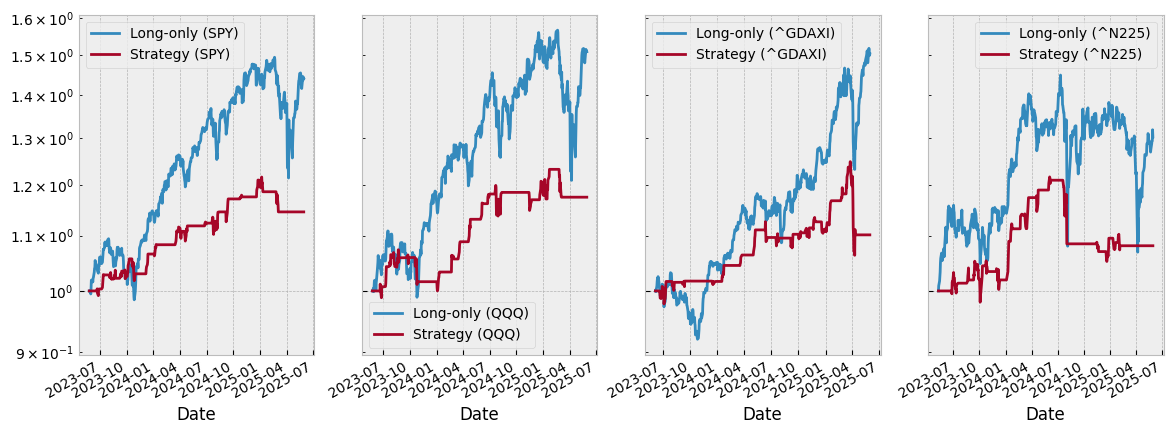

In [7]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_1_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 2

If the following conditions are met, go long the equity market for 5 days.
- It the market made new 10-day lows
- Price is above 200 day MA. Rationale is to go long when long-term trend is up and capture temporal pullback.

In [8]:
def run_strat_2(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.LocalMinimum(lookback=10, shift=1)
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [9]:
strategy_2_result = run_backtests(run_strat_2, instruments)

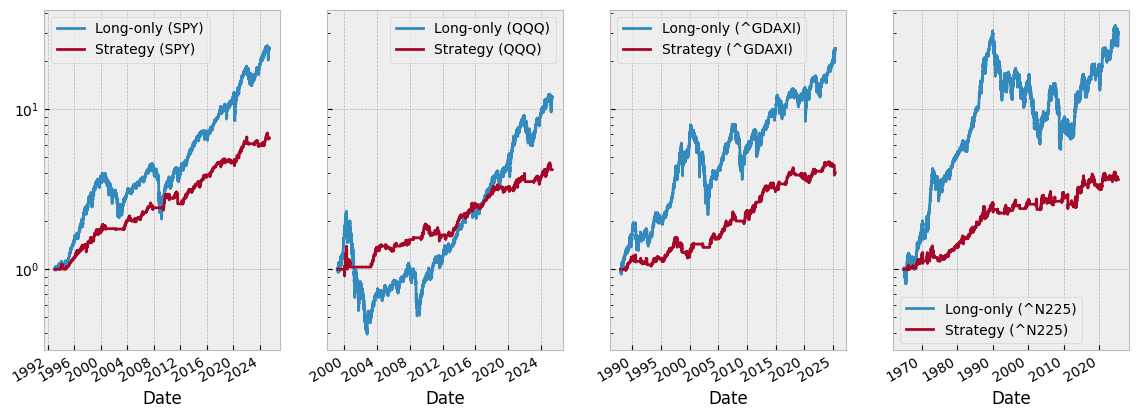

In [10]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_2_result):
    result.plot(ax=ax, logy=True)

In [11]:
pd.concat([i.pipe(Performance).summary() for i in strategy_2_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.098551,0.058617,0.094918,0.054765,0.084541,0.037062,0.057829,0.021930
Annualised vol,0.187460,0.081782,0.272596,0.113221,0.218252,0.088707,0.202727,0.087114
Sharpe ratio,0.525719,0.716749,0.348202,0.483697,0.387356,0.417800,0.285253,0.251742
Max drawdown,0.551895,0.163105,0.829639,0.282275,0.726848,0.256756,0.818712,0.219014
Calmar ratio,0.178569,0.359383,0.114409,0.194012,0.116312,0.144346,0.070634,0.100133
Skewness,-0.006552,-0.582978,0.234319,0.677596,-0.126134,-0.300715,-0.204191,-2.430653
Kurtosis,11.738899,27.250958,7.046536,45.341386,6.585399,16.900470,9.353043,79.574801
Worst return,-0.109424,-0.072473,-0.119788,-0.086647,-0.131434,-0.058299,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072473,-0.119788,-0.086647,-0.131434,-0.058299,-0.149009,-0.149009
Worst 1w return,-0.197934,-0.081136,-0.246190,-0.246190,-0.216097,-0.087830,-0.243342,-0.127345


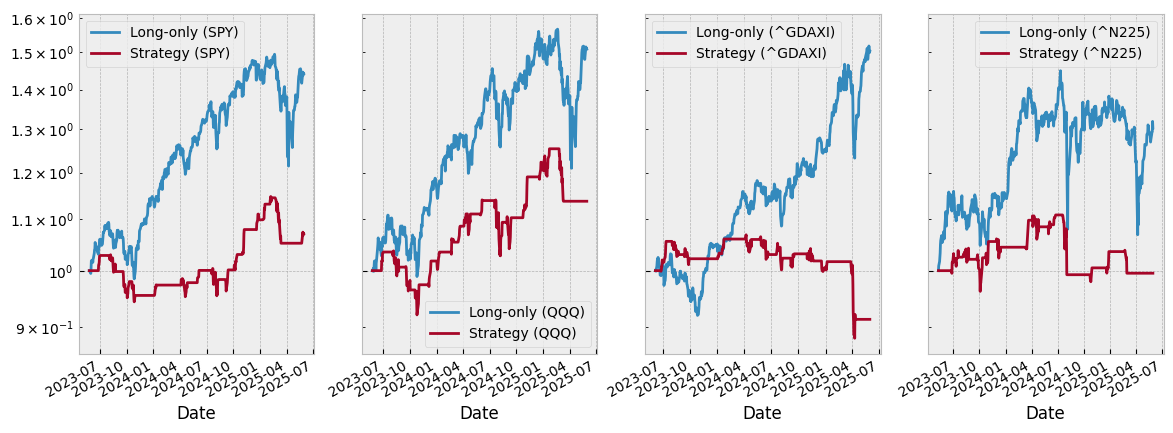

In [12]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_2_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 3

This strategy is the so-called "Double 7's strategy".

In [13]:
def run_strat_3(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Double7Connors(),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [14]:
strategy_3_result = run_backtests(run_strat_3, instruments)

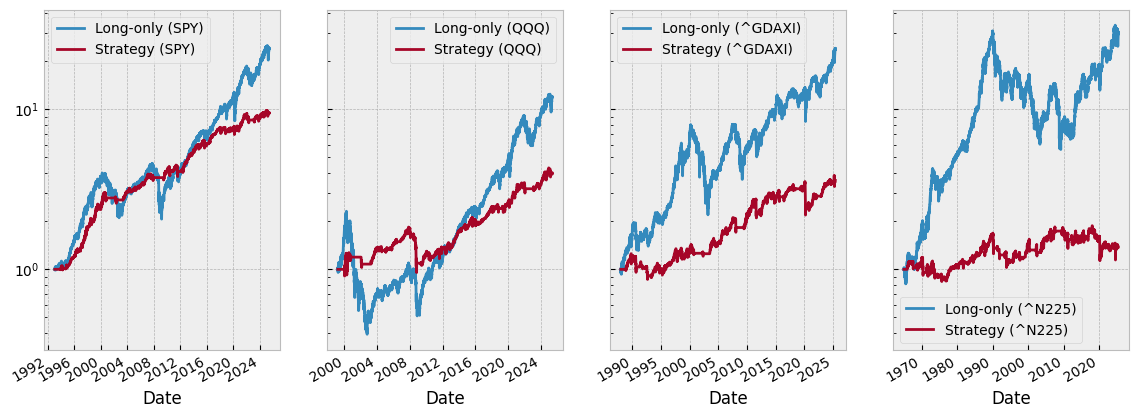

In [15]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_3_result):
    result.plot(ax=ax, logy=True)

In [16]:
pd.concat([i.pipe(Performance).summary() for i in strategy_3_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.098551,0.069872,0.094918,0.053026,0.084541,0.034091,0.057829,0.005472
Annualised vol,0.187460,0.097897,0.272596,0.141833,0.218252,0.116955,0.202727,0.108220
Sharpe ratio,0.525719,0.713724,0.348202,0.373862,0.387356,0.291484,0.285253,0.050561
Max drawdown,0.551895,0.153226,0.829639,0.480136,0.726848,0.382193,0.818712,0.395910
Calmar ratio,0.178569,0.456006,0.114409,0.110439,0.116312,0.089197,0.070634,0.013820
Skewness,-0.006552,-0.311000,0.234319,0.606297,-0.126134,-1.181963,-0.204191,-1.694188
Kurtosis,11.738899,17.352346,7.046536,32.048018,6.585399,36.470109,9.353043,51.656997
Worst return,-0.109424,-0.072473,-0.119788,-0.089557,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072473,-0.119788,-0.089557,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1w return,-0.197934,-0.111611,-0.246190,-0.246190,-0.216097,-0.200123,-0.243342,-0.159939


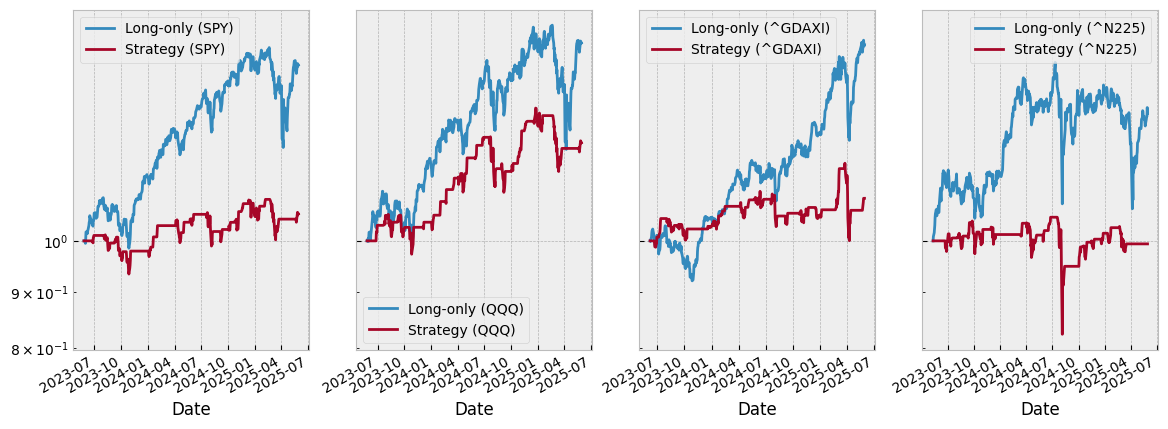

In [17]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_3_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 4
Month-end strategy which goes long when the following conditions are met:
- n days before month-end
    - (optional) only do so when the previous day is down
- The price is above 200 day MA

In [18]:
def run_strat_4(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.MonthEndLong(n_before=5, n_after=0, is_prev_neg=True),
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [19]:
strategy_4_result = run_backtests(run_strat_4, instruments)

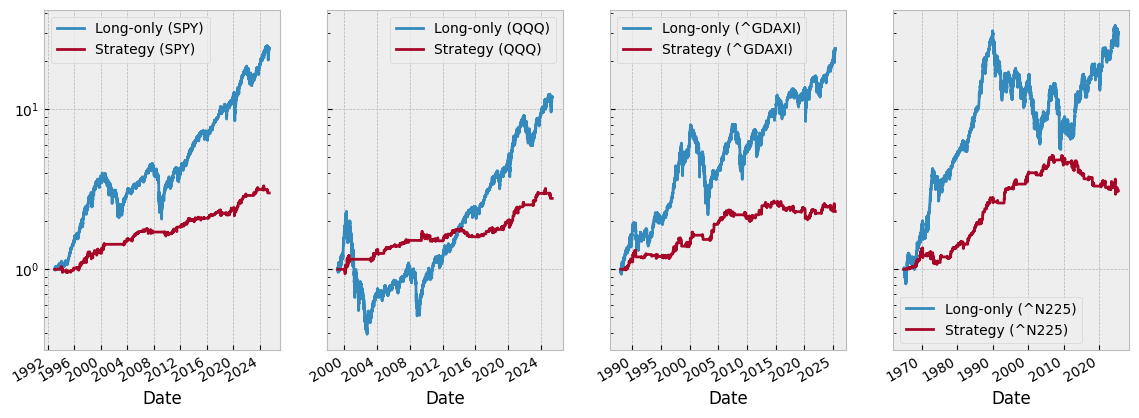

In [20]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_4_result):
    result.plot(ax=ax, logy=True)

In [21]:
pd.concat([i.pipe(Performance).summary() for i in strategy_4_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.098551,0.034034,0.094918,0.039008,0.084541,0.022174,0.057829,0.019208
Annualised vol,0.187460,0.061424,0.272596,0.081093,0.218252,0.067230,0.202727,0.063148
Sharpe ratio,0.525719,0.554082,0.348202,0.481028,0.387356,0.329827,0.285253,0.304181
Max drawdown,0.551895,0.111611,0.829639,0.134186,0.726848,0.238856,0.818712,0.428543
Calmar ratio,0.178569,0.304936,0.114409,0.290699,0.116312,0.092836,0.070634,0.044823
Skewness,-0.006552,-0.798642,0.234319,0.403172,-0.126134,-0.447107,-0.204191,-2.553400
Kurtosis,11.738899,46.168664,7.046536,39.179445,6.585399,28.290231,9.353043,151.409963
Worst return,-0.109424,-0.072473,-0.119788,-0.057516,-0.131434,-0.049530,-0.149009,-0.123958
Worst 1d return,-0.109424,-0.072473,-0.119788,-0.057516,-0.131434,-0.049530,-0.149009,-0.123958
Worst 1w return,-0.197934,-0.111611,-0.246190,-0.106266,-0.216097,-0.124379,-0.243342,-0.127345


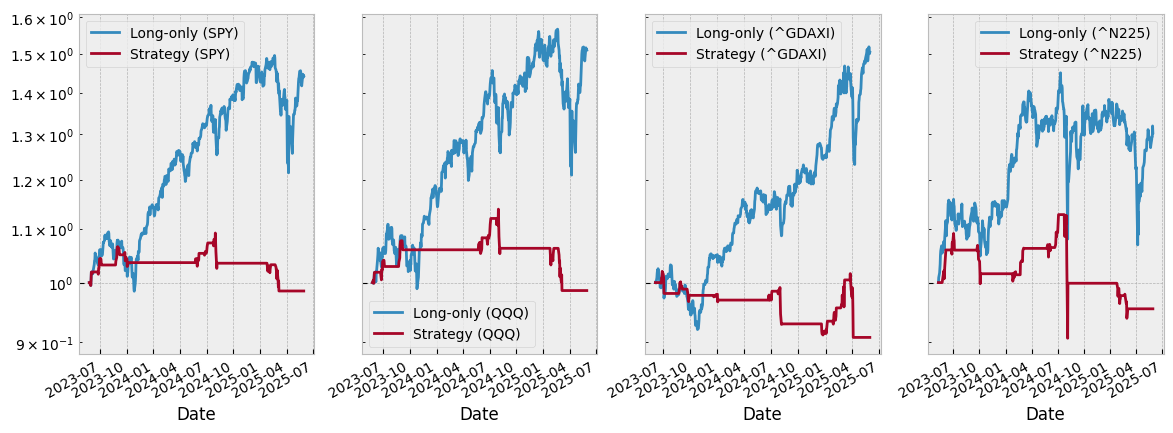

In [22]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_4_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Reference
- Connors, L.A. and Alvarez, C., 2009. Short Term Trading Strategies that Work: A Quantified Guide to Trading Stocks and ETFs. TradingMarkets Publishing Group.

In [23]:
print(f'Updated: {datetime.now(pytz.utc):%d-%b-%Y %H:%M}')

Updated: 02-Jun-2025 08:02
